In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel("C:\\Users\\mathi\\Downloads\\Final_Data_with_2024 (1).xlsx")
df = df.apply(pd.to_numeric, errors='coerce')

In [6]:
#Dropping prognosis features
columns_to_drop = ["Weekend", "Christmas vacation", "Public holiday", "Winter Time", "System Price Lag 1", "System Price Lag 2", "System Price Lag 3", "System Price Lag 24", "System Price Lag 48", "System Price Lag 168"]
df_dropped = df.drop(columns=columns_to_drop, errors='ignore')


In [8]:
import pandas as pd



#order of columns
columns_ordered = [
    'System Price', 'NO1 Price', 'NO2 Price', 'NO3 Price', 'NO4 Price', 'NO5 Price', 
    'SE1 Price', 'SE2 Price', 'SE3 Price', 'SE4 Price', 'DK1 Price', 'DK2 Price', 'FI Price', 
    "Total Production", "Total Consumption" ,'Oil', 'Coal', 'Gas', 'Permit',  
    'Settled wind production SE', 
    'Settled wind production DK', 'Settled wind production FI',"Settled wind production NO", "Temp NO", "Precip NO"
]


df_reordered = df_dropped[columns_ordered]


df_reordered.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56064 entries, 0 to 56063
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   System Price                56064 non-null  float64
 1   NO1 Price                   56064 non-null  float64
 2   NO2 Price                   56064 non-null  float64
 3   NO3 Price                   56064 non-null  float64
 4   NO4 Price                   56064 non-null  float64
 5   NO5 Price                   56064 non-null  float64
 6   SE1 Price                   56064 non-null  float64
 7   SE2 Price                   56064 non-null  float64
 8   SE3 Price                   56064 non-null  float64
 9   SE4 Price                   56064 non-null  float64
 10  DK1 Price                   56064 non-null  float64
 11  DK2 Price                   56064 non-null  float64
 12  FI Price                    56064 non-null  float64
 13  Total Production            560

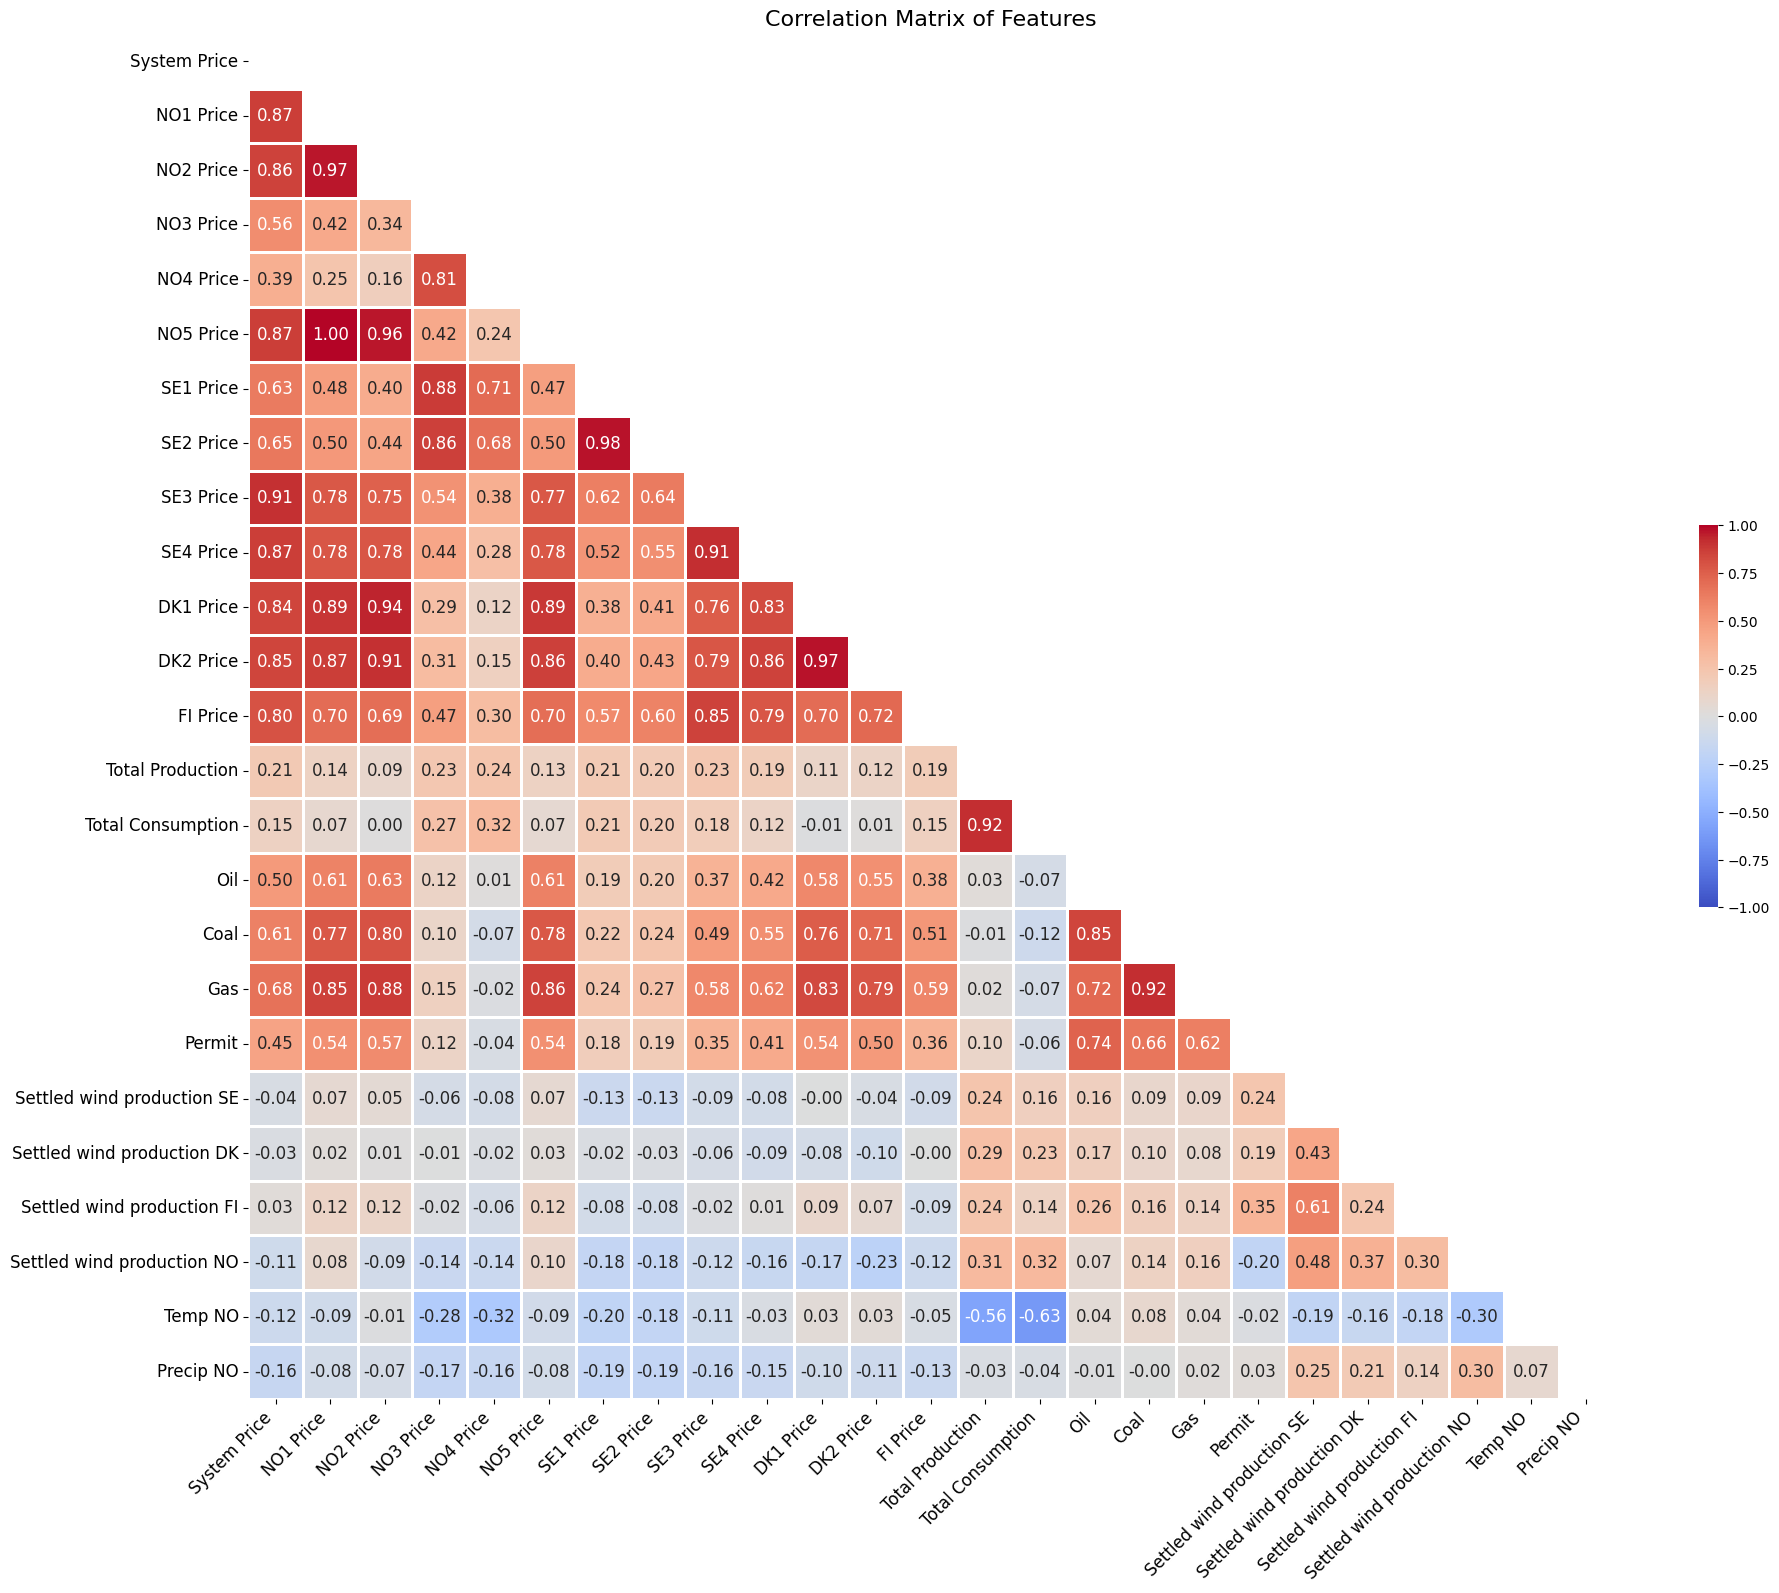

In [17]:
plt.figure(figsize=(20, 20))  
plt.style.use("default")

df_corr = df_reordered.corr(method="pearson")
mask = np.triu(np.ones_like(df_corr, dtype=bool))

#cmap = sns.diverging_palette(240, 10, as_cmap=True)
cmap = "coolwarm"


sns.heatmap(df_corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            vmin=-1, 
            center=0, 
            square=True, 
            linewidths=2, 
            annot=True,
            fmt=".2f", 
            cbar_kws={"shrink": 0.2},
            annot_kws={"size": 12})  


plt.xticks(rotation=45, ha='right', size=12) 
plt.yticks(rotation=0, size=12)  


plt.title('Correlation Matrix of Features', size=16)

plt.tight_layout(pad = 2.0)  
plt.show()


## Binary Segmentation and chow test

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import statsmodels.api as sm
from scipy.stats import f

df = pd.read_excel("C:\\Users\\mathi\\Downloads\\Final_Data_with_2024.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index("DateTime", inplace=True)
df = df.asfreq('H')
df.ffill(inplace=True)

df = df.loc['2018-01-01':'2024-05-31']

prices = df['System Price'].values


In [3]:
#Binary Segmentation for detecting two change points
model = "l2"
algo_binseg = rpt.Binseg(model=model).fit(prices)
breakpoints_binseg = algo_binseg.predict(n_bkps=2)




In [26]:
# Perform Chow Test at identified breakpoints
def chow_test(data, breakpoint):
    data_pre = data[:breakpoint]
    data_post = data[breakpoint:]
    
    X_pre = sm.add_constant(np.arange(len(data_pre)))
    X_post = sm.add_constant(np.arange(len(data_post)))
    
    model_pre = sm.OLS(data_pre, X_pre).fit()
    model_post = sm.OLS(data_post, X_post).fit()
    
    RSS_pre = np.sum(model_pre.resid**2)
    RSS_post = np.sum(model_post.resid**2)
    
    X_full = sm.add_constant(np.arange(len(data)))
    model_full = sm.OLS(data, X_full).fit()
    RSS_full = np.sum(model_full.resid**2)
    
    n = len(data)
    k = model_full.df_model + 1  # number of parameters
    
    F_stat = ((RSS_full - (RSS_pre + RSS_post)) / k) / ((RSS_pre + RSS_post) / (n - 2 * k))
    p_value = 1 - f.cdf(F_stat, k, n - 2 * k)
    
    return F_stat, p_value

# Test the breakpoints identified by Binary Segmentation
chow_results_binseg = [chow_test(prices, bp) for bp in breakpoints_binseg[:-1]]  


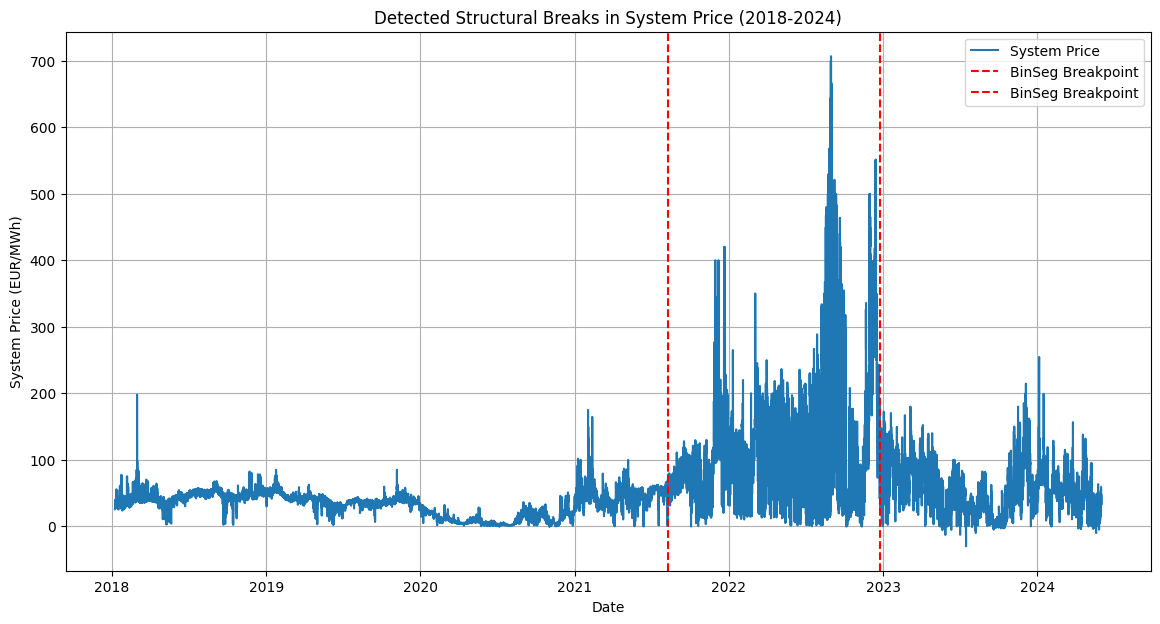

In [4]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df.index, prices, label='System Price')
for breakpoint in breakpoints_binseg[:-1]:
    plt.axvline(df.index[breakpoint], color='red', linestyle='--', label='BinSeg Breakpoint')
plt.legend()
plt.title('Detected Structural Breaks in System Price (2018-2024)')
plt.xlabel('Date')
plt.ylabel('System Price (EUR/MWh)')
plt.grid(True)
plt.show()



# Chow results

In [29]:

for i, bp in enumerate(breakpoints_binseg[:-1]):
    F_stat, p_value = chow_results_binseg[i]
    explanation = (
        f"BinSeg Breakpoint at {df.index[bp]}: "
        f"F-statistic = {F_stat:.2f}, p-value = {p_value:.5f}. "
        "indicates a significant structural break at this point."
    )
    print(explanation)


BinSeg Breakpoint at 2021-08-09 09:00:00: F-statistic = 7587.54, p-value = 0.00000. A low p-value (typically < 0.05) indicates a significant structural break at this point.
BinSeg Breakpoint at 2022-12-25 22:00:00: F-statistic = 4377.84, p-value = 0.00000. A low p-value (typically < 0.05) indicates a significant structural break at this point.
